# Single Track Kinemematic Study

This code experiments with the single track kinematic model commonly used in autonomous vehicle research.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate as grate
from math import cos, sin, pi
from functools import partial

Assume there is a 2D intertial frame ($\mathbb{R}^2$) with basis vectors $e_x$ and $e_y$.
The single track kinematic model assumes two non-slip wheels with center points that are co-linear along a rigid link with length $l$.

There are two important angles in the model:

1. $\theta$ - the angle between $p_f - p_r$ and $e_x$
2. $\delta$ - the rotation angle between the front wheel's forward velocity, $\dot{p}_f$, and $p_f - p_r$.

Let's consider the model for the front wheel:

$\dot{x}_f = v_f cos(\theta + \delta)$

$\dot{y}_f = v_f cos(\theta + \delta)$

$\dot{\theta} = \frac{v_f}{l}\sin{\delta}$


The front and rear wheel speeds are related by:
$$
\frac{v_r}{v_f}=\cos{\theta}
$$

The control problem involves choosing a forward speed, $v_f \in {[v_{min},v_{max}]}$, and some steering angle, $\delta \in {[\delta_{min},\delta_{mx}]}$.

Time to throw some numerical tools at this model...

In [2]:
def single_track_front(t, p, l, u_func):
    '''
    Parameters:
    t (float) - current time
    p (vector[float]) - vehicle configuration, [x, y, theta]
    l (float) - length of rigid link between front and rear wheel
    u_func (function) - control input function
    '''
    theta = p[2]
    u = u_func(t, p)
    vf = u[0]
    delta = u[1]
    x_dot = vf * cos(theta + delta)
    y_dot = vf * sin(theta + delta)
    theta_dot = (vf / l)*sin(delta)
    return [x_dot, y_dot, theta_dot]

In [3]:
def constant_speed_osc(t, p, vf, period):
    '''
    Applies constant forward speed and sinusoidal steering based on t.
    '''
    return [vf, sin(period * t)]

In [4]:
# Test the function out to make sure it works with reasonable input.
u_func = partial(constant_speed_osc, vf=1.0, period=2*pi)

model = partial( single_track_front, l=1.0, u_func=u_func )
model(0.0, [0.0,0.0,0.0])

[1.0, 0.0, 0.0]

In [5]:
def simulate(model_func, tspan, init_state):
    # Chose RK23 after RK45 produced sparse results. Would require more tolerance tweaking
    sol = grate.solve_ivp( model_func, tspan, init_state, method='RK23', dense_output=False )
    return sol

In [6]:
# Simulate this system for 5 seconds with a constant steering angle
tf = 5.0
tspan = (0.0,tf)
# Vehicle's initial configuration, p = [x,y,theta]
p0 = [0.0,0.0,0.0]

# Chose RK23 after RK45 produced sparse results. Would require more tolerance tweaking
sol = simulate( model_func=model, tspan=tspan, init_state=p0 )

In [7]:
def plot_state_evolution(sol):
    X = sol.y[0,:]
    Y = sol.y[1,:]
    Theta = sol.y[2,:]
    plt.figure(num=1, figsize=(8,5))
    plt.subplot(2,1,1)
    plt.plot(X,Y,'b--')
    plt.ylabel("Y Position")
    plt.xlabel("X Position")
    plt.title("Vehicle Evolution")

    plt.subplot(2,1,2)
    plt.plot(sol.t,Theta,'r--')
    plt.ylabel("Vehicle Angle")
    plt.xlabel("Time ($t$)")
    plt.title("Vehicle Angle Evolution")

    plt.tight_layout()
    plt.show()

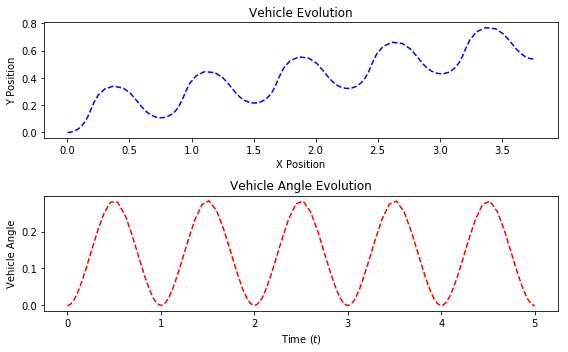

In [8]:
plot_state_evolution(sol)

The `single_track_front` model can still allow *instantaneous* steering angle changes and speeds, e.g. $\delta(0)=0.8 \textrm{ rad} \rightarrow \delta(0.1)=5 \textrm{ rad}$, which is not *physically* possible.

In [9]:
def constant_speed_spike(t, p, vf, period, t_switch):
    '''
    Applies constant forward speed and sinusoidal steering based on t.
    '''
    if t < t_switch:
        return [vf, sin(period * t)]
    else:
        return [vf, -0.5]

In [10]:
# Apply this new discontinuous controller
u_func_spike = partial(constant_speed_spike, vf=1.0, period=2*pi, t_switch=2.0)
model_alt = partial(single_track_front, l = 1.0, u_func=u_func_spike )

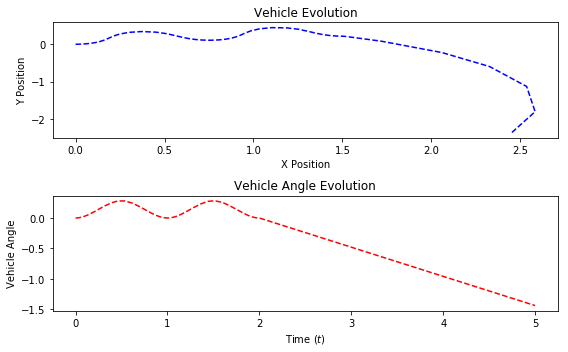

In [11]:
sol = simulate( model_func=model_alt, tspan=tspan, init_state=p0 )
plot_state_evolution(sol)

Consequently, one can augment the model with steering command rate, $\alpha := \dot{\delta}$, which is confined to $[\alpha_{min}, \alpha_{max}]$.

$\dot{x}_f = v_f cos(\theta + \delta)$

$\dot{y}_f = v_f cos(\theta + \delta)$

$\dot{\theta} = \frac{v_f}{l}\sin{\delta}$

$\dot{\delta} = \alpha$

The control inputs are now $v_f$ and $\alpha$.

In [12]:
def single_track_front_augmented(t, p, l, u_func):
    '''
    Parameters:
    t (float) - current time
    p (vector[float]) - vehicle configuration, [x, y, theta]
    l (float) - length of rigid link between front and rear wheel
    u_func (function) - control input function
    '''
    theta = p[2]
    delta = p[3]
    u = u_func(t, p)
    vf = u[0]
    alpha = u[1]
    x_dot = vf * cos(theta + delta)
    y_dot = vf * sin(theta + delta)
    theta_dot = (vf / l)*sin(delta)
    delta_dot = alpha
    return [x_dot, y_dot, theta_dot, delta_dot]

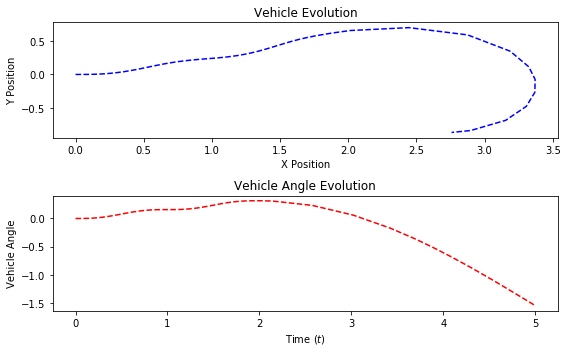

In [13]:
# I will use the same constant_speed_spike function to feed inputs, but now it is supplying steering rate.
model_augmented = partial( single_track_front_augmented, l=1.0, u_func=u_func_spike )
p0 = [0,0,0,0]
sol = simulate( model_func=model_augmented, tspan=tspan, init_state=p0 )
plot_state_evolution(sol)

The above plots illustrate how the use of a turn rate rather than direct turn angle result in a smoother trajectory.
However, added a fourth state to the model will increase planning complexity.